# Лабораторная №5 — «ручная» нейросеть на PyTorch (без `nn.Linear` и без `torch.optim`)
Датасет: **MNIST Dataset** (Kaggle, hojjatk) — файлы IDX (`*-images-idx3-ubyte`, `*-labels-idx1-ubyte`).  

В этом ноутбуке:
- Реализуем слои вручную: `Linear`, `ReLU`, `Dropout`, `Flatten`, `Softmax` (для инференса).
- Реализуем **Adam** вручную.
- Обучим несколько моделей (разные размеры/порядок слоёв), сравним графики и выберем лучшую.
- Добавим блок для **защиты**: загрузка вашей картинки (цифры, нарисованной преподавателем) и предсказание модели.

> Запрещено в задании: оборачивать готовые `nn.Linear`, `nn.Conv2d`, и т.п.  
> Разрешено: использовать **torch тензоры**, автоград, матричные операции, `DataLoader`, и т.п.


In [1]:
# !pip install -q kaggle  # если хотите качать датасет прямо из Colab через Kaggle API
import os, struct, math, time, random
from pathlib import Path

import numpy as np
import torch

import matplotlib.pyplot as plt
from PIL import Image, ImageOps

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())


torch: 2.9.1+cu128
cuda available: True


## 1) Загрузка MNIST из IDX-файлов (как в Kaggle датасете hojjatk)

Ожидаем наличие файлов:
- `train-images-idx3-ubyte` и `train-labels-idx1-ubyte`
- `t10k-images-idx3-ubyte` и `t10k-labels-idx1-ubyte`

Положите их в папку `DATA_DIR` (или поправьте путь).


In [3]:
DATA_DIR = Path("./")  # <-- поменяйте путь под себя (например /content/mnist)
# Пример для Colab (если вы вручную загрузили zip и распаковали):
# DATA_DIR = Path("/content/mnist")

def _read_idx_u8(path: Path):
    """Reads IDX file (uint8) and returns numpy array."""
    with path.open("rb") as f:
        magic = f.read(4)
        if len(magic) != 4:
            raise ValueError(f"Bad IDX file: {path}")
        zero, dtype, ndim = struct.unpack(">HBB", magic)
        if zero != 0:
            raise ValueError(f"Bad IDX header: {path}")
        if dtype != 0x08:
            raise ValueError(f"Only uint8 IDX supported, got dtype={dtype} for {path}")
        shape = tuple(struct.unpack(">I", f.read(4))[0] for _ in range(ndim))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(shape)

def load_mnist_from_idx(data_dir: Path):
    train_images = _read_idx_u8(data_dir / "train-images-idx3-ubyte")
    train_labels = _read_idx_u8(data_dir / "train-labels-idx1-ubyte")
    test_images  = _read_idx_u8(data_dir / "t10k-images-idx3-ubyte")
    test_labels  = _read_idx_u8(data_dir / "t10k-labels-idx1-ubyte")
    return (train_images, train_labels), (test_images, test_labels)

def maybe_load_fallback_torchvision():
    """Fallback: torchvision MNIST download (if kaggle files are missing)."""
    try:
        from torchvision.datasets import MNIST
        from torchvision import transforms
        root = "./torchvision_mnist"
        ds_tr = MNIST(root=root, train=True, download=True, transform=transforms.ToTensor())
        ds_te = MNIST(root=root, train=False, download=True, transform=transforms.ToTensor())
        Xtr = (ds_tr.data.numpy()).astype(np.uint8)
        ytr = (ds_tr.targets.numpy()).astype(np.uint8)
        Xte = (ds_te.data.numpy()).astype(np.uint8)
        yte = (ds_te.targets.numpy()).astype(np.uint8)
        return (Xtr, ytr), (Xte, yte)
    except Exception as e:
        raise RuntimeError("No Kaggle IDX files found and torchvision fallback failed.") from e

if (DATA_DIR / "train-images-idx3-ubyte").exists():
    (X_train_u8, y_train_u8), (X_test_u8, y_test_u8) = load_mnist_from_idx(DATA_DIR)
    print("Loaded Kaggle IDX MNIST from:", DATA_DIR)
else:
    print("Kaggle IDX files not found in:", DATA_DIR)
    print("Using torchvision fallback (only to make notebook runnable everywhere).")
    (X_train_u8, y_train_u8), (X_test_u8, y_test_u8) = maybe_load_fallback_torchvision()

print("Train:", X_train_u8.shape, y_train_u8.shape)
print("Test :", X_test_u8.shape, y_test_u8.shape)

# Normalize to float32 in [0,1]
X_train = (X_train_u8.astype(np.float32) / 255.0)
X_test  = (X_test_u8.astype(np.float32) / 255.0)

# Add channel dim for potential conv; for MLP we flatten later
X_train = X_train[:, None, :, :]  # (N,1,28,28)
X_test  = X_test[:, None, :, :]

y_train = y_train_u8.astype(np.int64)
y_test  = y_test_u8.astype(np.int64)


Loaded Kaggle IDX MNIST from: .
Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


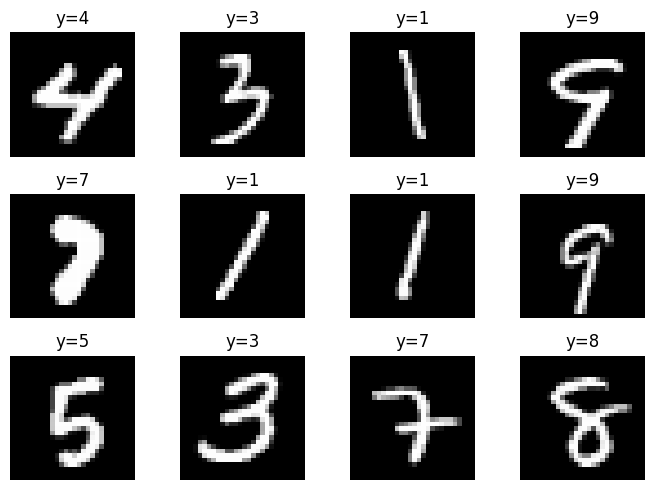

In [4]:
# sanity-plot a few images
idx = np.random.choice(len(X_train), size=12, replace=False)
fig, axes = plt.subplots(3, 4, figsize=(7, 5))
for ax, i in zip(axes.ravel(), idx):
    ax.imshow(X_train[i,0], cmap="gray")
    ax.set_title(f"y={y_train[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


## DataLoader


In [5]:
from torch.utils.data import Dataset, DataLoader

class NumpyMNIST(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # float32
        self.y = torch.from_numpy(y)  # int64
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NumpyMNIST(X_train, y_train)
test_ds  = NumpyMNIST(X_test, y_test)

BATCH_SIZE = 256
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

class Layer:
    def parameters(self):
        return []
    def train(self):
        self.training = True
        return self
    def eval(self):
        self.training = False
        return self
    def __call__(self, x):
        return self.forward(x)
    def forward(self, x):
        raise NotImplementedError

class Flatten(Layer):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Linear(Layer):
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        # Kaiming-like init for ReLU networks
        w = torch.randn(out_features, in_features) * math.sqrt(2.0 / in_features)
        b = torch.zeros(out_features)
        self.W = w.to(device).requires_grad_(True)
        self.b = b.to(device).requires_grad_(True)

    def forward(self, x):
        # x: (B, in_features)
        return x @ self.W.t() + self.b

    def parameters(self):
        return [self.W, self.b]

class ReLU(Layer):
    def forward(self, x):
        return torch.clamp(x, min=0.0)

class Dropout(Layer):
    def __init__(self, p=0.5):
        assert 0.0 <= p < 1.0
        self.p = p
        self.training = True

    def forward(self, x):
        if not getattr(self, "training", True) or self.p == 0.0:
            return x
        keep = 1.0 - self.p
        mask = (torch.rand_like(x) < keep).to(x.dtype)
        return (x * mask) / keep

class Softmax(Layer):
    def __init__(self, dim=-1):
        self.dim = dim
    def forward(self, x):
        x = x - x.max(dim=self.dim, keepdim=True).values
        exp = torch.exp(x)
        return exp / exp.sum(dim=self.dim, keepdim=True)

class Sequential(Layer):
    def __init__(self, *layers):
        self.layers = list(layers)
        self.training = True

    def forward(self, x):
        for layer in self.layers:
            if hasattr(layer, "training"):
                layer.training = getattr(self, "training", True)
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for l in self.layers:
            params.extend(l.parameters())
        return params

    def train(self):
        self.training = True
        for l in self.layers:
            if hasattr(l, "training"):
                l.training = True
        return self

    def eval(self):
        self.training = False
        for l in self.layers:
            if hasattr(l, "training"):
                l.training = False
        return self


In [8]:
def cross_entropy_logits(logits, y_true):
    """Mean CE over batch. logits: (B,C), y_true: (B,) int64"""
    # log-softmax
    logits = logits - logits.max(dim=1, keepdim=True).values
    logsumexp = torch.log(torch.exp(logits).sum(dim=1, keepdim=True))
    log_probs = logits - logsumexp
    nll = -log_probs[torch.arange(logits.shape[0], device=logits.device), y_true]
    return nll.mean()

@torch.no_grad()
def accuracy_from_logits(logits, y_true):
    preds = logits.argmax(dim=1)
    return (preds == y_true).float().mean().item()


In [9]:
class Adam:
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        self.params = list(params)
        self.lr = lr
        self.b1, self.b2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    @torch.no_grad()
    def step(self):
        self.t += 1
        lr = self.lr
        b1, b2 = self.b1, self.b2
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            g = p.grad
            if self.weight_decay != 0.0:
                g = g + self.weight_decay * p

            self.m[i].mul_(b1).add_(g, alpha=(1 - b1))
            self.v[i].mul_(b2).addcmul_(g, g, value=(1 - b2))

            m_hat = self.m[i] / (1 - b1 ** self.t)
            v_hat = self.v[i] / (1 - b2 ** self.t)

            p.add_(m_hat / (torch.sqrt(v_hat) + self.eps), alpha=-lr)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [10]:
def train_one_epoch(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        loss = cross_entropy_logits(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = X.shape[0]
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits.detach(), y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        loss = cross_entropy_logits(logits, y)
        bs = X.shape[0]
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

def fit(model, lr=1e-3, epochs=8, weight_decay=0.0, verbose=True):
    opt = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for ep in range(1, epochs+1):
        tr_l, tr_a = train_one_epoch(model, opt, train_loader)
        te_l, te_a = evaluate(model, test_loader)
        history["train_loss"].append(tr_l)
        history["train_acc"].append(tr_a)
        history["test_loss"].append(te_l)
        history["test_acc"].append(te_a)
        if verbose:
            print(f"epoch {ep:02d}/{epochs} | train loss {tr_l:.4f} acc {tr_a:.4f} | test loss {te_l:.4f} acc {te_a:.4f}")
    return history

def plot_histories(histories, title=""):
    fig = plt.figure(figsize=(10,4))
    plt.title(title)
    
    plt.subplot(1,2,1)
    for name, h in histories.items():
        plt.plot(h["train_loss"], label=f"{name} train")
        plt.plot(h["test_loss"],  linestyle="--", label=f"{name} test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True, alpha=0.2)

    plt.subplot(1,2,2)
    for name, h in histories.items():
        plt.plot(h["train_acc"], label=f"{name} train")
        plt.plot(h["test_acc"],  linestyle="--", label=f"{name} test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()


In [11]:
def make_model_A():
    return Sequential(
        Flatten(),
        Linear(28*28, 128),
        ReLU(),
        Linear(128, 10),
    )

def make_model_B():
    return Sequential(
        Flatten(),
        Linear(28*28, 256),
        ReLU(),
        Dropout(0.2),
        Linear(256, 128),
        ReLU(),
        Linear(128, 10),
    )

def make_model_C():
    return Sequential(
        Flatten(),
        Linear(28*28, 512),
        ReLU(),
        Dropout(0.3),
        Linear(512, 10),
    )

models = {
    "MLP-A": make_model_A(),
    "MLP-B": make_model_B(),
    "MLP-C": make_model_C(),
}

# quick parameter counts
def count_params(model):
    return sum(p.numel() for p in model.parameters())

for k, m in models.items():
    print(k, "params:", count_params(m))


MLP-A params: 101770
MLP-B params: 235146
MLP-C params: 407050



==== MLP-A ====
epoch 01/10 | train loss 0.4424 acc 0.8799 | test loss 0.2235 acc 0.9375
epoch 02/10 | train loss 0.1948 acc 0.9453 | test loss 0.1645 acc 0.9507
epoch 03/10 | train loss 0.1452 acc 0.9593 | test loss 0.1368 acc 0.9596
epoch 04/10 | train loss 0.1155 acc 0.9673 | test loss 0.1146 acc 0.9656
epoch 05/10 | train loss 0.0969 acc 0.9728 | test loss 0.1036 acc 0.9683
epoch 06/10 | train loss 0.0819 acc 0.9770 | test loss 0.0929 acc 0.9718
epoch 07/10 | train loss 0.0715 acc 0.9799 | test loss 0.0925 acc 0.9701
epoch 08/10 | train loss 0.0617 acc 0.9824 | test loss 0.0858 acc 0.9739
epoch 09/10 | train loss 0.0544 acc 0.9847 | test loss 0.0825 acc 0.9733
epoch 10/10 | train loss 0.0477 acc 0.9867 | test loss 0.0792 acc 0.9749

==== MLP-B ====
epoch 01/10 | train loss 0.3667 acc 0.8932 | test loss 0.1499 acc 0.9557
epoch 02/10 | train loss 0.1454 acc 0.9566 | test loss 0.1068 acc 0.9674
epoch 03/10 | train loss 0.1031 acc 0.9688 | test loss 0.0857 acc 0.9739
epoch 04/10 | tra

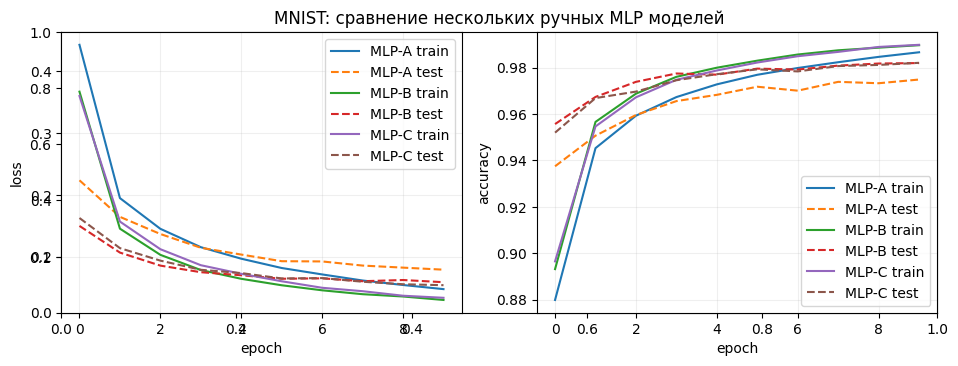

In [12]:
EPOCHS = 10
LR = 1e-3

histories = {}
for name, model in models.items():
    print("\n====", name, "====")
    set_seed(42)  # for fair-ish comparison
    histories[name] = fit(model, lr=LR, epochs=EPOCHS)

plot_histories(histories, title="MNIST: сравнение нескольких ручных MLP моделей")


### 6.2) Выбор лучшей модели

In [13]:
best_name = max(histories.keys(), key=lambda n: max(histories[n]["test_acc"]))
best_acc = max(histories[best_name]["test_acc"])
print("Best model:", best_name, "| best test acc:", best_acc)

best_model = models[best_name]
best_model.eval()


Best model: MLP-C | best test acc: 0.9821


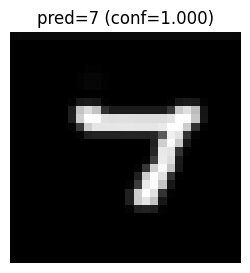

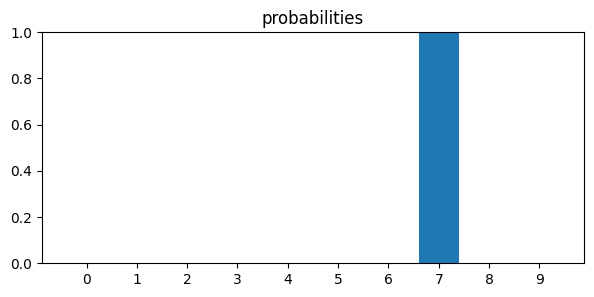

In [15]:
def preprocess_single_image(path: str):
    img = Image.open(path).convert("L")  # grayscale
    # crop to content
    img_np = np.array(img)
    # If background is white and digit is dark, invert like MNIST
    if img_np.mean() > 127:
        img = ImageOps.invert(img)

    # make square canvas
    w, h = img.size
    side = max(w, h)
    canvas = Image.new("L", (side, side), 0)
    canvas.paste(img, ((side - w)//2, (side - h)//2))
    img = canvas

    # resize to 28x28
    img = img.resize((28, 28), Image.BILINEAR)

    x = np.array(img).astype(np.float32) / 255.0
    x = x[None, None, :, :]  # (1,1,28,28)
    return torch.from_numpy(x).to(device), img

@torch.no_grad()
def predict_image(model, path: str):
    x, vis = preprocess_single_image(path)
    logits = model(x)
    probs = Softmax(dim=1)(logits)
    pred = int(probs.argmax(dim=1).item())
    conf = float(probs.max(dim=1).values.item())
    return pred, conf, probs.squeeze(0).cpu().numpy(), vis

# Put your image path here:
IMAGE_PATH = "./Screenshot_20251215_181200.png"

if Path(IMAGE_PATH).exists():
    pred, conf, probs, vis = predict_image(best_model, IMAGE_PATH)
    plt.figure(figsize=(3,3))
    plt.imshow(vis, cmap="gray")
    plt.title(f"pred={pred} (conf={conf:.3f})")
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(7,3))
    plt.bar(np.arange(10), probs)
    plt.xticks(np.arange(10))
    plt.ylim(0, 1)
    plt.title("probabilities")
    plt.show()
else:
    print("Файл не найден:", IMAGE_PATH)
    print("Загрузите картинку (PNG/JPG) и укажите путь в IMAGE_PATH.")
